#  극도로 편향된 신용카드 사기 거래 data 분류
## Logistic Regression, Random Forest, Over/Under-sampling

- Highly Imbalanced Dataset - 284,807 거래 건 중 492 개의 사기거래


- [Credit Card Fraud Detection](https://www.kaggle.com/mlg-ulb/creditcardfraud) - Kaggle


- Highly Imbalanced Dataset - dataset는 2013 년 9 월 유럽 카드 소지자 신용 카드 거래로 만들었습니다. 이 dataset는 2 일 동안 발생한 거래를 보여 주며, 284,807 건의 거래 중 492 건의 fraud가 있습니다. 데이터세트는 매우 불균형하며 포지티브 클래스(사기)는 모든 거래의 0.172 %를 차지합니다.


- 이 dataset는 PCA 변환의 결과인 숫자 입력 변수만 포함합니다. 안타깝게도 기밀 유지 문제로 인해 데이터에 대한 원래 feature와 추가 background 정보를 제공할 수 없습니다. 특성 V1, V2, ... V28은 PCA로 얻은 principal component이며 PCA로 변환되지 않은 유일한 기능은 'Time' 과 'Amount' 입니다. '시간' 특성은 각 트랜잭션과 데이터 세트의 첫 번째 트랜잭션 사이에 경과된 시간(초) 입니다. 'Amount' 특성은 거래금액 입니다.  'Class'는 사기의 경우 1, 그렇지 않으면 0 입니다.


- 클래스 불균형 비율이 주어지면 Area Under the Precision-Recall Curve (AUPRC)을 사용하여 정확도를 측정하는 것이 좋습니다. 불균형 data 분류에는 confusion matrix 정확도가 의미가 없습니다.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.metrics import  accuracy_score, precision_score, recall_score, \
                            roc_curve, roc_auc_score
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

import tensorflow as tf
import tensorflow.keras.layers as layers

### Download the Kaggle Credit Card Fraud data set

In [2]:
# raw_df = pd.read_csv('https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv')
df = pd.read_csv('data/creditcard.csv')

df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


numpy.bincount(x, weights=None, minlength=0)

- list x 의 각 value 별 빈도수 구하기   
- return list 의 길이는 np.amax(x) + 1  
```
ex)
np.bincount([0, 1, 1, 0, 1, 0, 1, 3])
array([3, 4, 0, 1], dtype=int64)
```

In [3]:
df['Class'].unique()

array([0, 1])

In [4]:
neg, pos = np.bincount(df['Class'])
print(neg, pos)

total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n' \
       .format(total, pos, 100 * pos / total))

284315 492
Examples:
    Total: 284807
    Positive: 492 (0.17% of total)



### Clean, split and normalize the data

In [5]:
cleaned_df = df.copy()

# Time 을 일중 시간으로 변환
cleaned_df.loc[:, "Time"] = cleaned_df.loc[:, "Time"].apply(lambda x : x / 3600 % 24) 

# Amount column 은 편차가 크므로 log-scale 로 변환
eps=0.001      # 0 => 0.1¢
cleaned_df['Amount'] = np.log(cleaned_df.pop('Amount') + eps)

cleaned_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Class,Amount
0,0.000000,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,5.008105
1,0.000000,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,0.989913
2,0.000278,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,5.936641
3,0.000278,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,4.816249
4,0.000556,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,4.248367


In [6]:
cleaned_df['Amount'].describe()

count    284807.000000
mean          2.942089
std           2.023685
min          -6.907755
25%           1.722945
50%           3.091088
75%           4.345959
max          10.153902
Name: Amount, dtype: float64

In [7]:
labels = np.array(cleaned_df.pop('Class'))
labels

array([0, 0, 0, ..., 0, 0, 0])

In [8]:
features = cleaned_df.values
features.shape

(284807, 30)

dataset 을 Training 과 Test set 으로 분리

In [9]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, 
                                            test_size=0.25, random_state=0)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(213605, 30)
(71202, 30)
(213605,)
(71202,)


## Feature Scaling

In [10]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test  = sc.transform(X_test)

### Training set 에 대해 Logistic Regression model 을 fitting

In [11]:
lr_clf = LogisticRegression(random_state=0)
lr_clf.fit(X_train, y_train)

LogisticRegression(random_state=0)

### predict

- predict() - 확률 0.5 이상으로 예측된 class 를 positive case 로 반환   


- predict_proba() - class 의 probability 반환 ([negative 확률, positive 확률])

In [12]:
y_pred = lr_clf.predict(X_test)

print("Test set true counts = ", sum(y_test))
print("predicted true counts = ", sum(y_pred))
print("accuracy = {:.5f}".format(sum(y_pred == y_test) / len(y_test)))

Test set true counts =  120
predicted true counts =  89
accuracy = 0.99928


In [13]:
y_pred_proba = lr_clf.predict_proba(X_test)

y_pred_proba_1 = y_pred_proba[:, 1]

sum(y_pred_proba_1 > 0.5)

89

## confusion matrix 를 이용한 model 평가

In [14]:
def plot_cm(y_test, y_pred_proba, threshold):
    
    y_predict = y_pred_proba > threshold
    
    cm = confusion_matrix(y_test, y_predict)
    
    print("confution matrix\n", cm)
    print()
    print("f1 score\n", f1_score(y_test, y_predict))
    print()
    print("Accuracy: {:.5f}".format(accuracy_score(y_test, y_predict)))
    print("Precision: {:.5f}".format(precision_score(y_test, y_predict)))
    print("Recall: {:.5f}".format(recall_score(y_test, y_predict)))
    
    plt.figure(figsize=(5,5))

    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @>{:.2f} '.format(threshold))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

confution matrix
 [[71072    10]
 [   41    79]]

f1 score
 0.7559808612440191

Accuracy: 0.99928
Precision: 0.88764
Recall: 0.65833


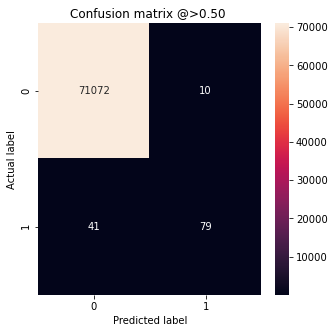

In [15]:
plot_cm(y_test, y_pred_proba_1, 0.5)

### Fraud 거래를 잡아내는 것이 목적이므로, fraud case 를 놓치지 않으려면 recall 을 높인다.

이를 위해 threshold 를 0.2 로 조정.

confution matrix
 [[71067    15]
 [   31    89]]

f1 score
 0.7946428571428571

Accuracy: 0.99935
Precision: 0.85577
Recall: 0.74167


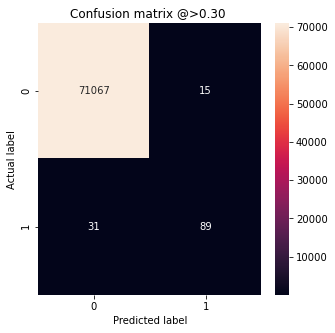

In [16]:
plot_cm(y_test, y_pred_proba_1, 0.3)

## Oversample the minority class / Undersample the majority class

- 단순히 THRESHOLD 를 조정하여 recall 을 높이는 것은 한계가 있으므로 minority data 의 수를 증가시켜 새로이 fitting

- minority class 를 oversampling 에 의해 dataset 에서 다시 resample 

- majority class 를 undersampling에 의해 dataset 에서 다시 resample

In [17]:
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

In [18]:
over = RandomOverSampler(sampling_strategy=0.1)
X, y = over.fit_resample(features, labels)
X.shape, y.shape, Counter(y)

((312746, 30), (312746,), Counter({0: 284315, 1: 28431}))

In [19]:
under = RandomUnderSampler(sampling_strategy=0.5)
X, y = under.fit_resample(X, y)
X.shape, y.shape, Counter(y)

((85293, 30), (85293,), Counter({0: 56862, 1: 28431}))

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((68234, 30), (17059, 30), (68234,), (17059,))

In [21]:
re_lr_clf = LogisticRegression(max_iter=1000, random_state=0)
re_lr_clf.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=0)

In [22]:
y_pred_proba = re_lr_clf.predict_proba(X_test)

y_pred_proba_2 = y_pred_proba[:, 1]

sum(y_pred_proba_2 > 0.5)

5195

confution matrix
 [[11249   125]
 [  615  5070]]

f1 score
 0.931985294117647

Accuracy: 0.95662
Precision: 0.97594
Recall: 0.89182


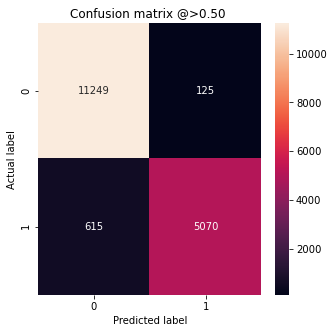

In [23]:
plot_cm(y_test, y_pred_proba_2, 0.5)

## RandomForest 를 이용한 Classification

In [24]:
%%time
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, verbose=1)
rf.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


CPU times: user 18.8 s, sys: 43.1 ms, total: 18.9 s
Wall time: 18.9 s


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   18.9s finished


RandomForestClassifier(verbose=1)

In [25]:
y_pred = rf.predict(X_test)

print("Test set true counts = ", sum(y_test))
print("predicted true counts = ", sum(y_pred))
print("accuracy = {:.5f}".format(sum(y_pred == y_test) / len(y_test)))

Test set true counts =  5685
predicted true counts =  5689
accuracy = 0.99977


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished


In [26]:
rf.feature_importances_
cleaned_df.columns
sorted(list(zip(cleaned_df.columns, rf.feature_importances_)), 
       key=lambda kv: kv[1], reverse=True)

[('V14', 0.18228173134713124),
 ('V10', 0.1567147630927696),
 ('V17', 0.12600393263131013),
 ('V4', 0.10681765175740099),
 ('V12', 0.09140558694834665),
 ('V11', 0.04685899377019687),
 ('V16', 0.04578599080860186),
 ('V9', 0.034009762878589575),
 ('V3', 0.0289178802344582),
 ('V18', 0.018973925043780773),
 ('V2', 0.015847062819015444),
 ('V7', 0.015335507583021551),
 ('V21', 0.015317671170484649),
 ('Amount', 0.009514183816053056),
 ('V8', 0.00932665349278281),
 ('V6', 0.009030560356105942),
 ('V1', 0.008769685936203255),
 ('V19', 0.008661913823753125),
 ('V20', 0.00750131711469223),
 ('V26', 0.007263429193360527),
 ('V5', 0.007183399980432151),
 ('V13', 0.007033527740214843),
 ('V15', 0.006500290048193027),
 ('V23', 0.005935758898541487),
 ('V28', 0.005351142049541918),
 ('Time', 0.005222241916527549),
 ('V22', 0.005161019721259057),
 ('V27', 0.004602961550346023),
 ('V25', 0.004548141363409137),
 ('V24', 0.004123312913476434)]

In [27]:
y_pred_proba = rf.predict_proba(X_test)

y_pred_proba_2 = y_pred_proba[:, 1]

sum(y_pred_proba_2 > 0.5)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished


5689

confution matrix
 [[11370     4]
 [    0  5685]]

f1 score
 0.9996483207314929

Accuracy: 0.99977
Precision: 0.99930
Recall: 1.00000


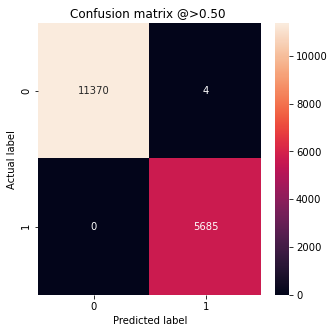

In [28]:
plot_cm(y_test, y_pred_proba_2, 0.5)

## Visualize ROC

roc_curve(y_true, y_score)  

fpr - false positive rates,  tpr - true positive rates

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished


Text(0.5, 1.0, 'ROC Curve')

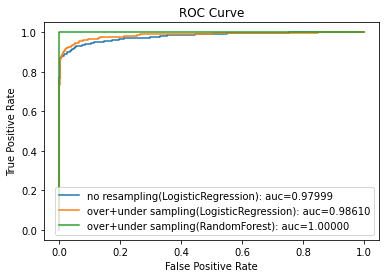

In [29]:
y_probas = lr_clf.predict_proba(X_test)
y_scores = y_probas[:,1]
fpr, tpr, _ = roc_curve(y_test, y_scores)
auc = roc_auc_score(y_test, y_scores)
plt.plot(fpr, tpr, 
         label="no resampling(LogisticRegression): auc="+ "{:.5f}".format(auc))

y_probas = re_lr_clf.predict_proba(X_test)
y_scores = y_probas[:,1]
fpr, tpr, _ = roc_curve(y_test, y_scores)
auc = roc_auc_score(y_test, y_scores)
plt.plot(fpr, tpr, 
         label="over+under sampling(LogisticRegression): auc="+ "{:.5f}".format(auc))

y_probas = rf.predict_proba(X_test)
y_scores = y_probas[:,1]
fpr, tpr, _ = roc_curve(y_test, y_scores)
auc = roc_auc_score(y_test, y_scores)
plt.plot(fpr, tpr, 
         label="over+under sampling(RandomForest): auc="+ "{:.5f}".format(auc))

plt.legend(loc=4)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')

## IE (Integrated Error)

- FAR : False Rejection Rate  

- FAR : False Acceptance Rate

FAR = FPR = FP/(FP + TN)

FRR = FNR = FN/(FN + TP)

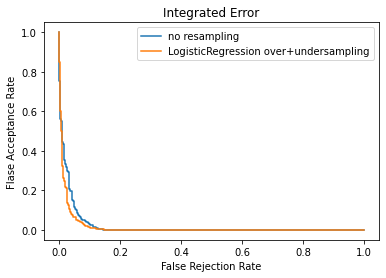

In [31]:
from sklearn.metrics import roc_curve

y_probas = lr_clf.predict_proba(X_test)
y_scores = y_probas[:,1]
fpr, tpr, _ = roc_curve(y_test, y_scores)
fnr = 1 - tpr
plt.plot(fnr, fpr, label='no resampling')

y_probas = re_lr_clf.predict_proba(X_test)
y_scores = y_probas[:,1]
fpr, tpr, _ = roc_curve(y_test, y_scores)
fnr = 1 - tpr
plt.plot(fnr, fpr, label='LogisticRegression over+undersampling')

plt.title("Integrated Error")
plt.xlabel('False Rejection Rate')
plt.ylabel('Flase Acceptance Rate')
plt.legend()